In [157]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json 
import networkx as nx

# Set path to your service account key
service_account_path = '/Users/CalvinLii/.dbt/dbt-tutorial-428919-05cddae3d3b7.json'

# Initialize the BigQuery client
client = bigquery.Client.from_service_account_json(service_account_path)


In [158]:
query = """
SELECT 
    *
FROM 
    `dbt-tutorial-428919.dbt_curriculum_rec.topic`
"""

# Execute the query and convert to a DataFrame
try: 
    topic = client.query(query).to_dataframe()
    print(topic.head())
except Exception as e: 
    print(f"An error occurred: {e}")

/opt/anaconda3/envs/ds/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   document_kind_count  video_kind_count  exercise_kind_count  \
0                    0                 0                    0   
1                    0                 0                    0   
2                    0                 0                    0   
3                    0                 0                    0   
4                    0                 0                    0   

   audio_kind_count  html5_kind_count  kind_total_count        id_topic  \
0                 0                 0                 0  t_342dce61daec   
1                 0                 0                 0  t_5d9f9b2022b6   
2                 0                 0                 0  t_084674fd1bd4   
3                 0                 0                 0  t_3eee08602be5   
4                 0                 0                 0  t_35947eb4763c   

   nan_holder_count  rice_university_holder_count  khan_academy_holder_count  \
0                 0                             0                          0  

In [177]:
import matplotlib.pyplot as plt

def find_content_distribution(topic_id, df=topic):
    """
    : param topic_id; int, the topic id to find the content distribution for
    : param df: DataFrame, the DataFrame containing the topic data
    """
    topic_data = df[df['id_topic'] == topic_id]

    # Prepare data for the pie chart
    labels = ['Document', 'Video', 'Exercise', 'Audio', 'HTML5']
    columns = ['document_kind_count', 'video_kind_count', 'exercise_kind_count', 'audio_kind_count', 'html5_kind_count']
    counts = topic_data[columns].iloc[0].values

    holder_labels = [col for col in topic_data.columns if 'holder_count' in col and (topic_data[col] != 0).any()]
    filtered_topic_data = topic_data[holder_labels]
    holder_counts = filtered_topic_data.iloc[0].values

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the first pie chart (holder counts)
    axes[0].pie(holder_counts, labels=holder_labels, autopct='%1.1f%%', startangle=140)
    axes[0].set_title('Copyright Holder Counts Distribution')

    # Plot the second pie chart (content counts)
    axes[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    axes[1].set_title('Content Kind Distribution')

    # Display the title
    plt.suptitle(f'Content Distribution for Topic ID: {topic_id}')
    
    # Save the figure to a file
    plt.savefig(f'images/content_distribution_{topic_id}.png')

    # Display the plots
    plt.show()


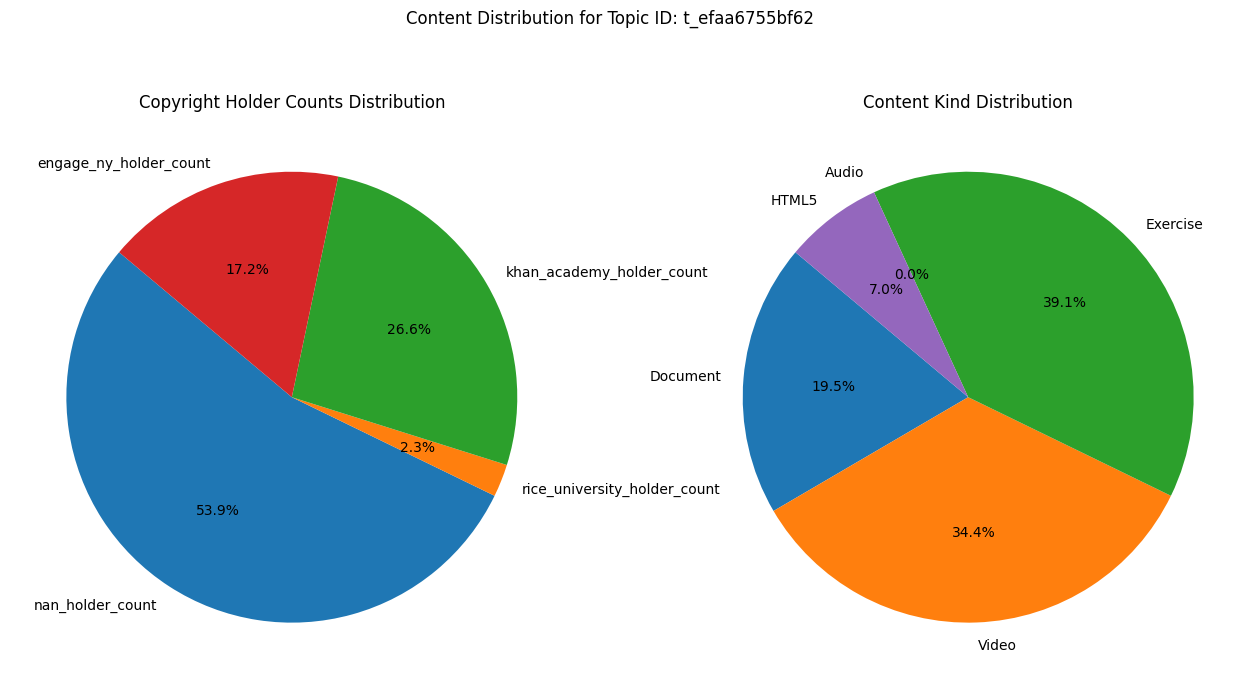

In [178]:
find_content_distribution('t_efaa6755bf62')

In [161]:
query = """
SELECT 
    *
FROM 
    `dbt-tutorial-428919.dbt_curriculum_rec.content`
"""

# Execute the query and convert to a DataFrame
try: 
    content = client.query(query).to_dataframe()
    print(content.head())
except Exception as e: 
    print(f"An error occurred: {e}")

/opt/anaconda3/envs/ds/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


       id_content content_title  \
0  c_7c1b6611c43d            Pi   
1  c_7c1b6611c43d            Pi   
2  c_13d067306b29           Air   
3  c_13d067306b29           Air   
4  c_eeb9f3f92e48           Ann   

                                 content_description cat_content_kind  \
0                                               None            html5   
1                                               None            html5   
2                                               None            video   
3                                               None            video   
4  Let ’ s make friends with Ann . What type of i...            video   

  content_text content_copyright_holder id_content_license        id_topic  \
0         None                      nan               None  t_14d78bb6f8d8   
1         None                      nan               None  t_af60036954e3   
2         None                      nan               None  t_c4e8e4ffe5ed   
3         None                      na

In [174]:
def find_topic_hierarchy(content_id, df=content): 
    """
    :param content_id: str, the id of the content 
    :param df: pd.DataFrame, the DataFrame containing the content data
    """
    # Assuming json_data is your JSON string
    content_data = df[df['id_content'] == content_id]
    for index, content in content_data.iterrows(): 
        origin_id = content['id_topic']
        json_data = content['json_hierarchy']
        print(json_data)

        # Convert JSON string to Python list
        data = json.loads(json_data)

        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes with titles as labels
        for item in data:
            G.add_node(item['id_topic'], label=item['topic_title'])

        # Define node colors
        node_colors = ['red' if node == origin_id else 'lightblue' for node in G.nodes()]

        # Add edges based on parent-child relationships
        for item in data:
            if item['id_topic_parent']:
                G.add_edge(item['id_topic_parent'], item['id_topic'])

        # Position nodes using hierarchical layout
        pos = nx.spring_layout(G)

        # Draw the tree
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color=node_colors, arrows=True)
        plt.title("Hierarchy for Content ID: " + content_id)

        # Create legend
        red_patch = mpatches.Patch(color='red', label='Origin Topic')
        blue_patch = mpatches.Patch(color='lightblue', label='Other Topics')
        plt.legend(handles=[red_patch, blue_patch], loc='best')

        # Save the figure to a file
        plt.savefig(f'images/topic_hierarchy_{content_id}.png')
        plt.show()

[{"id_topic":"t_b05650fa8291","id_topic_parent":null,"val_topic_level":0,"topic_title":"LibreTexts Physics"},{"id_topic":"t_0ae208834325","id_topic_parent":"t_5f4ceaa6d7d7","val_topic_level":2,"topic_title":"Quantum Mechanics"},{"id_topic":"t_097d317afe29","id_topic_parent":"t_0ae208834325","val_topic_level":3,"topic_title":"Book : Quantum Mechanics ( Fowler )"},{"id_topic":"t_8d572616c218","id_topic_parent":"t_097d317afe29","val_topic_level":4,"topic_title":"9 : Perturbation Theory"},{"id_topic":"t_5f4ceaa6d7d7","id_topic_parent":"t_b05650fa8291","val_topic_level":1,"topic_title":"Bookshelves"}]


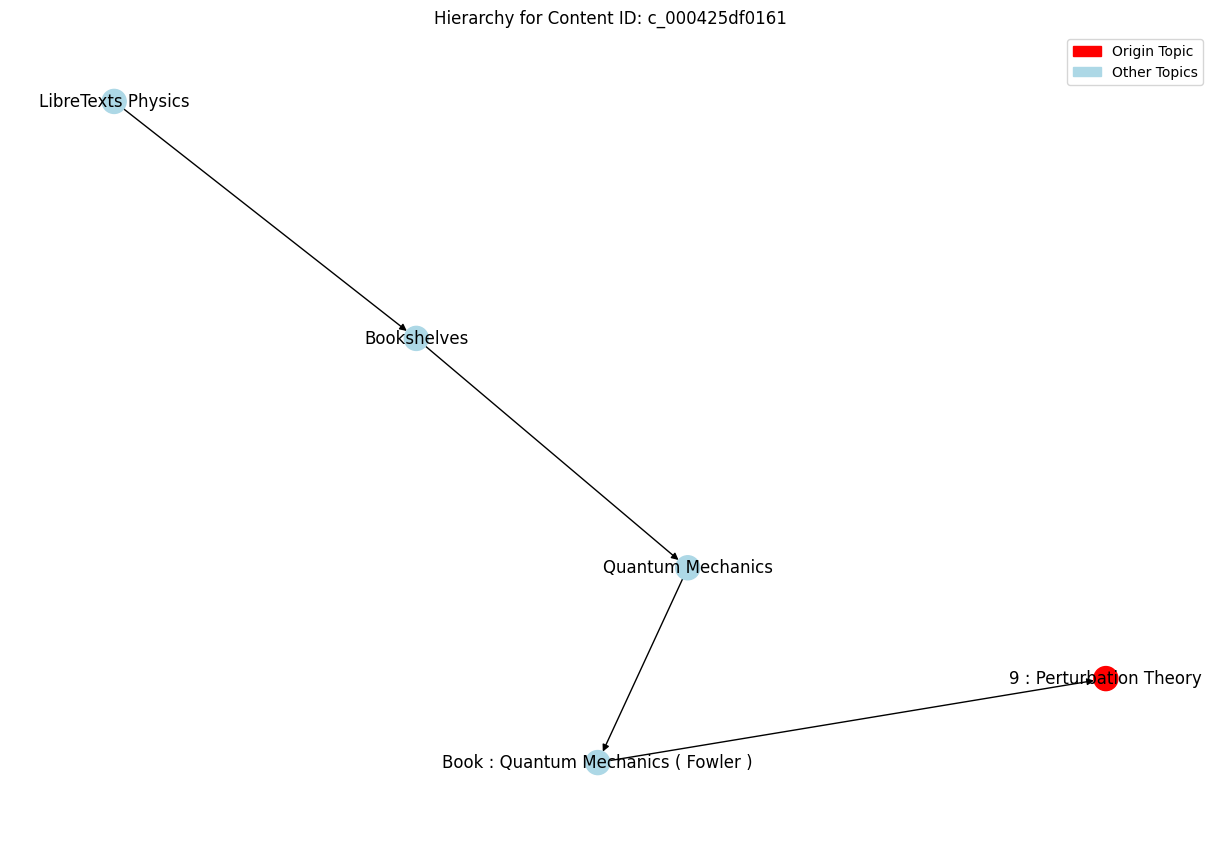

In [176]:
fig1 = find_topic_hierarchy('c_000425df0161')

[{"id_topic":"t_9c5061d10f64","id_topic_parent":"t_657e94fdcc35","val_topic_level":4,"topic_title":"9.2.3 Structure and functions of skin and kidney"},{"id_topic":"t_657e94fdcc35","id_topic_parent":"t_211df811ca0f","val_topic_level":3,"topic_title":"9.2 Excretion and homeostasis in animals"},{"id_topic":"t_02711ff7b62e","id_topic_parent":"t_ecd01c58c3fc","val_topic_level":1,"topic_title":"Form 2 Biology Curriculum"},{"id_topic":"t_ecd01c58c3fc","id_topic_parent":null,"val_topic_level":0,"topic_title":"KICD Biology Curriculum ( DRAFT )"},{"id_topic":"t_211df811ca0f","id_topic_parent":"t_02711ff7b62e","val_topic_level":2,"topic_title":"9.0 Excretion and homeostasis ( 42 lessons )"}]


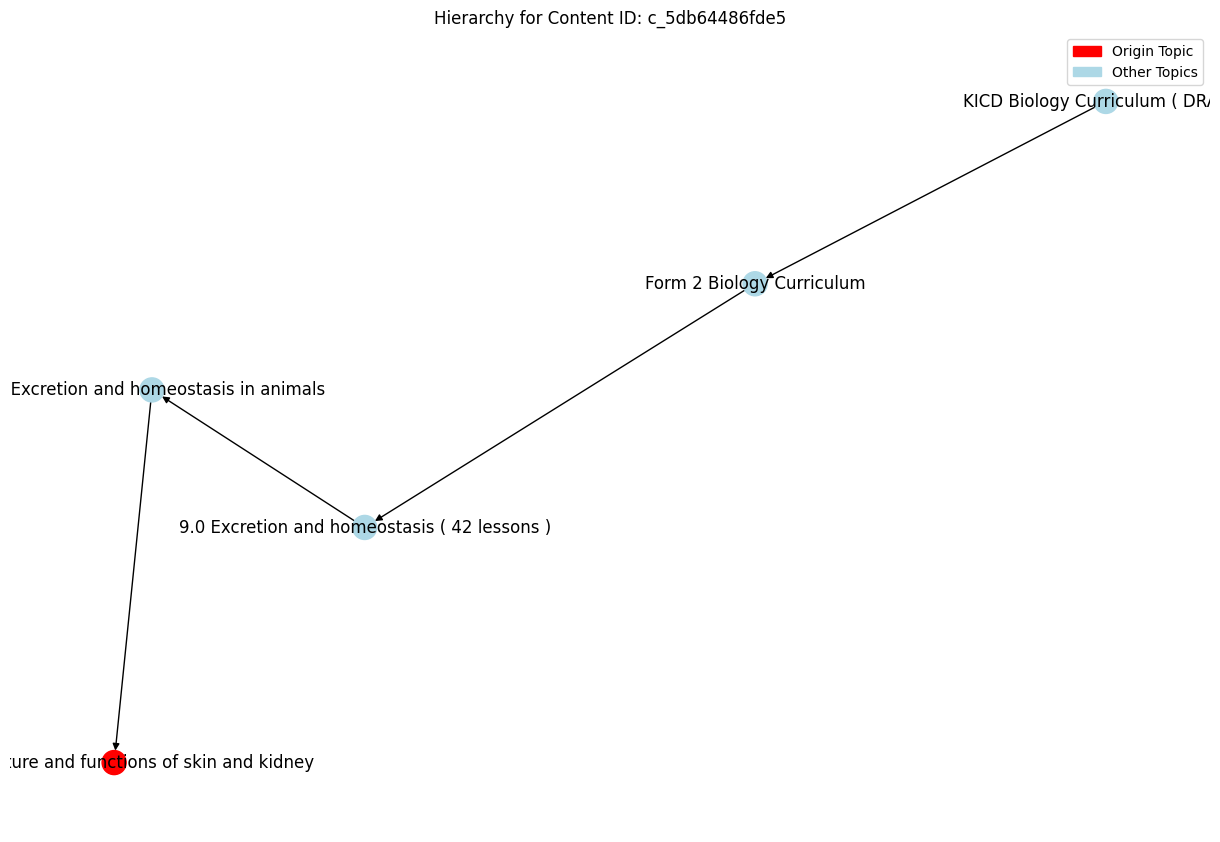

[{"id_topic":"t_51ba6ffbcc43","id_topic_parent":null,"val_topic_level":0,"topic_title":"K-12"},{"id_topic":"t_6894e48a3933","id_topic_parent":"t_51ba6ffbcc43","val_topic_level":1,"topic_title":"Science"},{"id_topic":"t_91b78c459f8c","id_topic_parent":"t_97ad5388e92e","val_topic_level":4,"topic_title":"Skin"},{"id_topic":"t_a122a9c1b22c","id_topic_parent":"t_6894e48a3933","val_topic_level":2,"topic_title":"Life Science"},{"id_topic":"t_97ad5388e92e","id_topic_parent":"t_a122a9c1b22c","val_topic_level":3,"topic_title":"Human Biology"}]


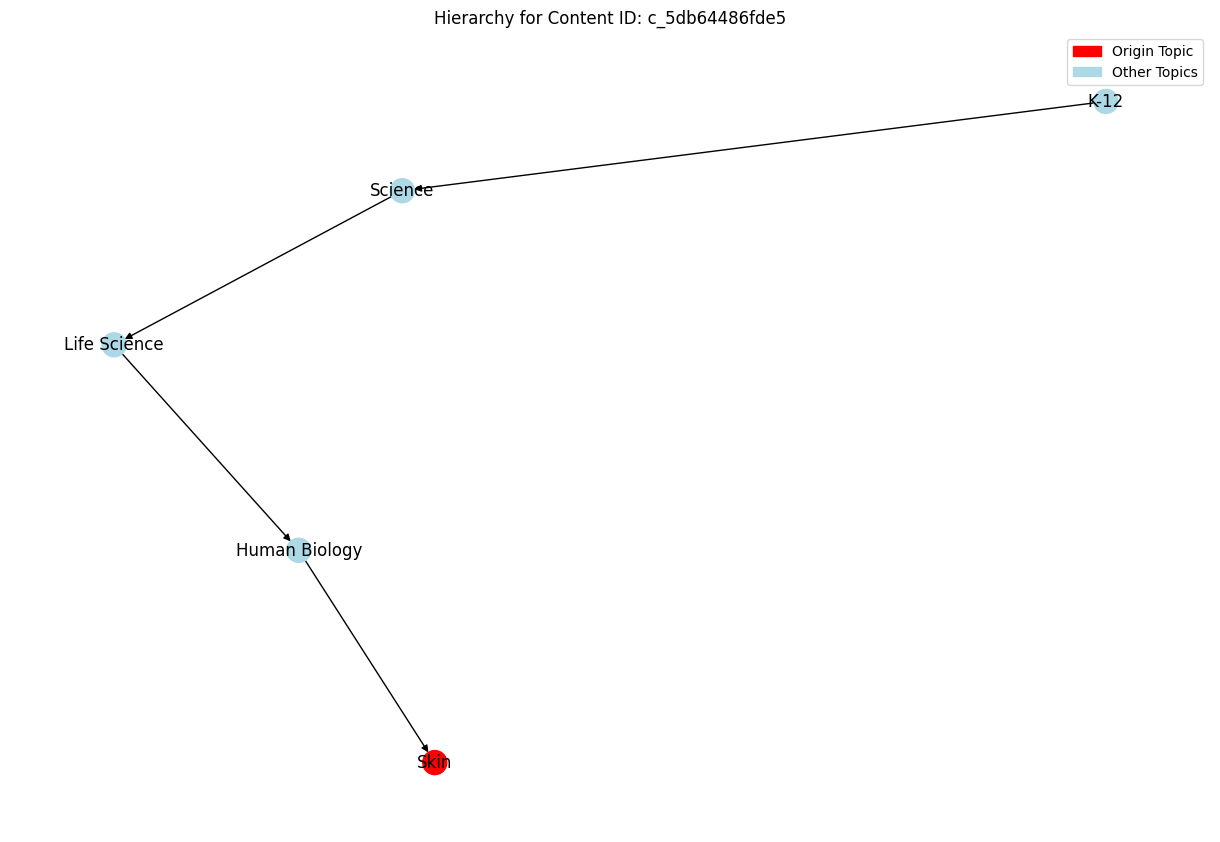

[{"id_topic":"t_f29263f324c8","id_topic_parent":"t_a2c985570357","val_topic_level":4,"topic_title":"9.2 Excretion and homeostasis in animals"},{"id_topic":"t_a5df51a220f4","id_topic_parent":"t_ba57eacbc263","val_topic_level":2,"topic_title":"Biology"},{"id_topic":"t_ba57eacbc263","id_topic_parent":"t_9a710f5bd2da","val_topic_level":1,"topic_title":"Form 2"},{"id_topic":"t_790da6ce3499","id_topic_parent":"t_f29263f324c8","val_topic_level":5,"topic_title":"9.2.3 Structure and functions of skin and kidney"},{"id_topic":"t_a2c985570357","id_topic_parent":"t_a5df51a220f4","val_topic_level":3,"topic_title":"9.0 Excretion and homeostasis ( 42 lessons )"},{"id_topic":"t_9a710f5bd2da","id_topic_parent":null,"val_topic_level":0,"topic_title":"Kolibri Library for Kenya"}]


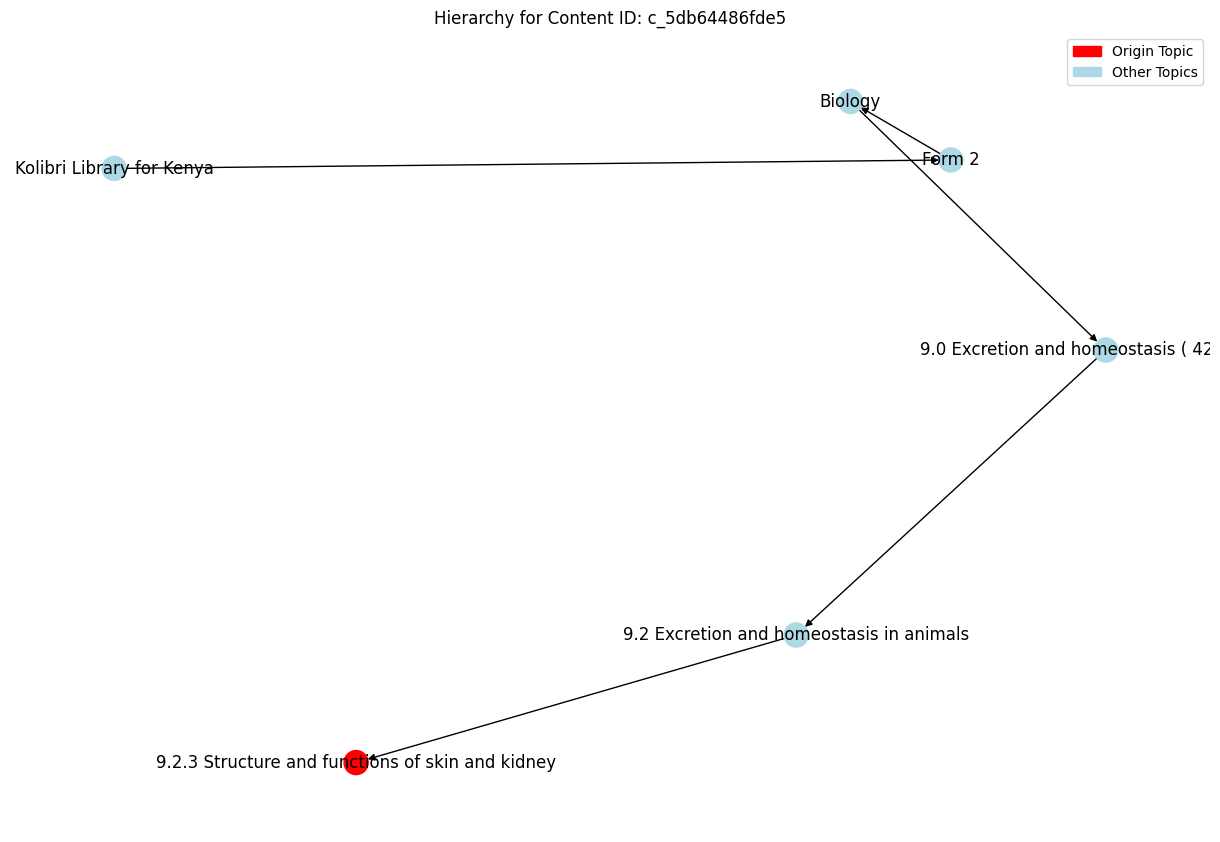

[{"id_topic":"t_7e9888b7da1a","id_topic_parent":"t_6894e48a3933","val_topic_level":2,"topic_title":"Biology"},{"id_topic":"t_ff1a69c389e6","id_topic_parent":"t_e510dfd0c1c3","val_topic_level":4,"topic_title":"Skin"},{"id_topic":"t_e510dfd0c1c3","id_topic_parent":"t_7e9888b7da1a","val_topic_level":3,"topic_title":"Human Biology"},{"id_topic":"t_51ba6ffbcc43","id_topic_parent":null,"val_topic_level":0,"topic_title":"K-12"},{"id_topic":"t_6894e48a3933","id_topic_parent":"t_51ba6ffbcc43","val_topic_level":1,"topic_title":"Science"}]


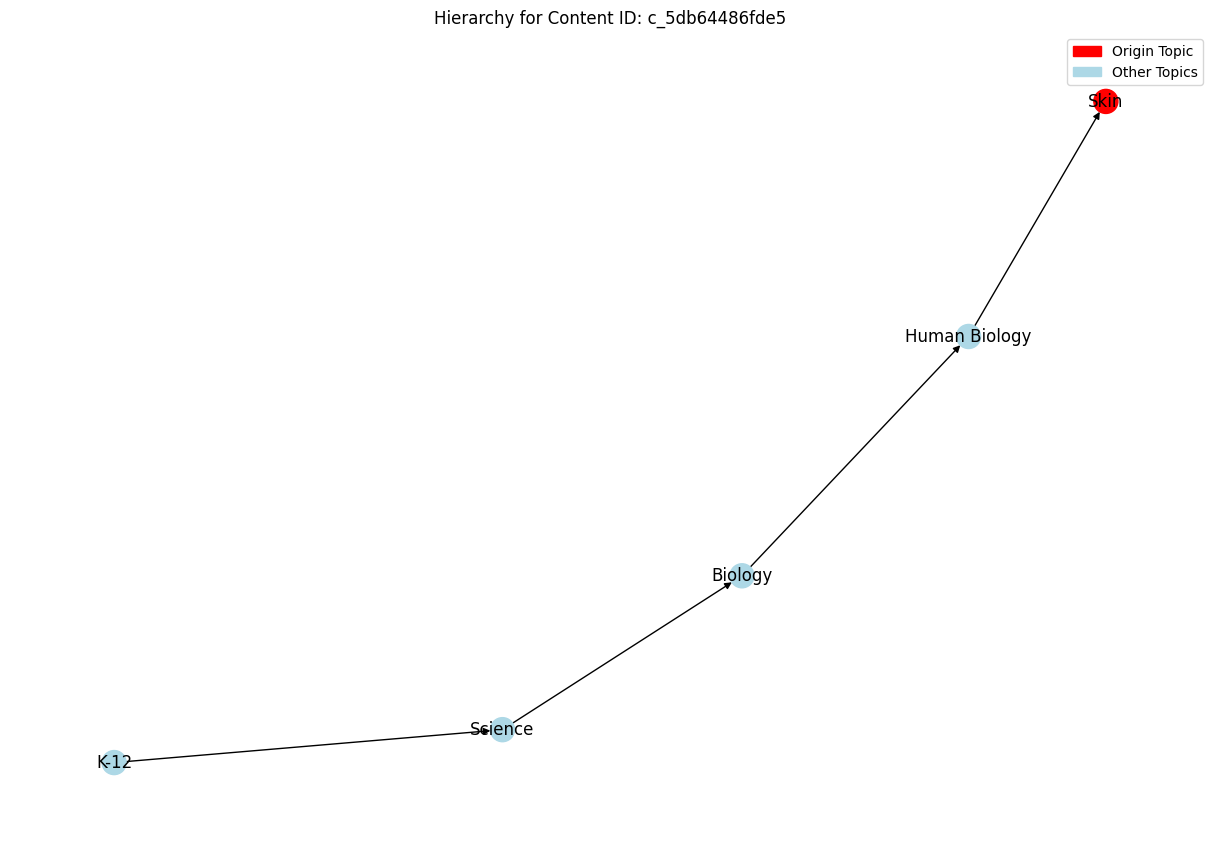

In [180]:
find_topic_hierarchy('c_5db64486fde5')